In [1]:
import MGBlurr.blurring as blur
import MGTomo.functions as fcts
from MGTomo.utils import mylog, mydiv
from MGTomo.optimize import armijo_linesearch, box_bounds, orthant_bounds
from MGTomo.gridop import RBox as R, PBox as P
from MGTomo import gridop

from skimage import data
from skimage.transform import resize
import matplotlib.pyplot as plt

import torch
from torch.linalg import matrix_norm

import time

In [2]:
N = 2047
max_levels = 6
maxIter = [1,2,16,32,64,128]
kernel_size = 11
sigma = 10

# load image
x_orig = data.camera()
x_orig = resize(x_orig, (N,N), anti_aliasing = False)

x_torch = torch.tensor(x_orig, requires_grad = True)

A = [blur.GaussianBlurOperator(N, kernel_size, sigma)]
b = [torch.poisson(A[0](x_torch)*50)/50]
P_nonzero = []

fine_dim = N
for i in range(1, max_levels+1):
    coarse_dim = blur.reduce_dim(fine_dim)
    A.append(blur.GaussianBlurOperator(coarse_dim, kernel_size, sigma))
    rhs = resize(b[-1].detach().numpy(), (coarse_dim, coarse_dim), anti_aliasing=False)
    b.append(torch.tensor(rhs, requires_grad=True)) #maybe use a different way to define bH
    P_nonzero.append(gridop.compute_nonzero_elements_of_P(coarse_dim))
    fine_dim = coarse_dim

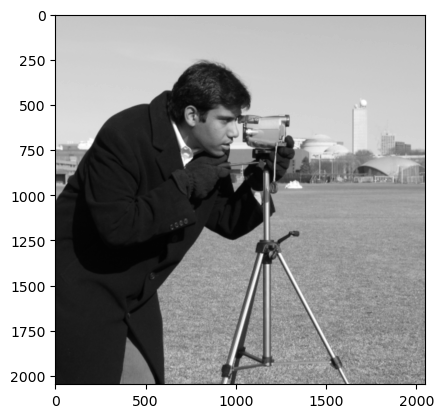

In [3]:
plt.imshow(x_orig, cmap='gray')

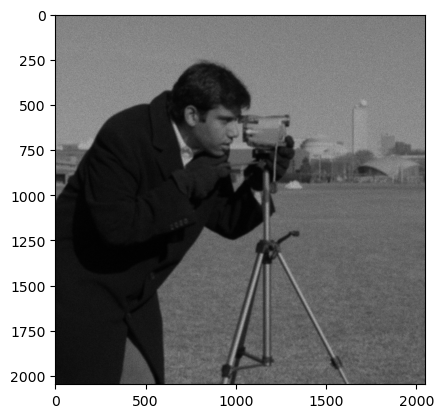

In [4]:
plt.imshow(b[0].detach(), cmap='gray')

In [5]:
def kl_distance_rev(x: torch.tensor, b: torch.tensor, A):
    ax = A(x)
    ax.requires_grad_(True)
    ba = mydiv(b,ax)
    
    erg = b * mylog(ba) - b + ax
    #fx = torch.sum(erg[b > 0.])
    fx = torch.sum( erg[ax > 0.]) + 0.5*torch.sum(b[ax == 0.]**2)
    assert fx >= 0, fx
    #assert fx >= 0, 'kl distance error: output is negative.'
    return fx.requires_grad_(True)

In [6]:
fh = lambda x: kl_distance_rev(x, b[0], A[0])
tau = [0.5 * torch.reciprocal(matrix_norm(bi, ord = 1)) for bi in b]
P_inf = 1

In [7]:
w0 = torch.ones(N, N, requires_grad = True)*0.5
lh = torch.zeros_like(w0)
w0.retain_grad()
#fh(w0).backward()
#w0.grad

fcts.mirror_descent_IS(fh, w0, tau[0], lh)

tensor([[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5001, 0.5001,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5001, 0.5001,  ..., 0.5000, 0.5000, 0.5000],
        ...,
        [0.5000, 0.4999, 0.4999,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.4999, 0.4999,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]])

In [8]:
w0 = torch.ones(N, N, requires_grad = True)*0.5
lh = torch.zeros_like(w0)

rel_f_err_SL = []
rel_f_err_SL.append((matrix_norm(w0 - x_torch)/matrix_norm(w0)).item())

iteration_times_SL = []
iteration_times_SL.append(0)
overall_start_time_SL = time.time()  # Start overall timing

w0.retain_grad()


for i in range(100):
    iteration_start_time_SL = time.time()  # Start timing for this iteration
    
    val = fcts.mirror_descent_IS(fh, w0, tau[0], lh)
    
    iteration_end_time_SL = time.time()  # End timing for this iteration
    iteration_time_SL = iteration_end_time_SL - iteration_start_time_SL  # Calculate elapsed time for this iteration
    
    iteration_times_SL.append(iteration_time_SL)
    w0 = val.clone().detach().requires_grad_(True)
    rel_f_err_SL.append((matrix_norm(w0-x_torch)/matrix_norm(w0)).item())
    
    print(f"Iteration {i}: {fh(w0)} - Time: {iteration_time_SL:.6f} seconds")

overall_end_time_SL = time.time()  # End overall timing
overall_time_SL = overall_end_time_SL - overall_start_time_SL  # Calculate overall elapsed time

print(f"Overall time for all iterations: {overall_time_SL:.6f} seconds")
cumaltive_times_SL = [sum(iteration_times_SL[:i+1]) for i in range(len(iteration_times_SL))]


Iteration 0: 470187.24415895314 - Time: 3.186874 seconds
Iteration 1: 470067.970173414 - Time: 3.227780 seconds
Iteration 2: 469948.73739972693 - Time: 3.179841 seconds
Iteration 3: 469829.5391150222 - Time: 3.254918 seconds
Iteration 4: 469710.3839342934 - Time: 3.180253 seconds
Iteration 5: 469591.2739687046 - Time: 3.159998 seconds
Iteration 6: 469472.2028775156 - Time: 3.201952 seconds
Iteration 7: 469353.17616132804 - Time: 3.209211 seconds
Iteration 8: 469234.19146948383 - Time: 3.234091 seconds
Iteration 9: 469115.2478676565 - Time: 3.240944 seconds
Iteration 10: 468996.34736433125 - Time: 3.126661 seconds
Iteration 11: 468877.48974938336 - Time: 3.192776 seconds
Iteration 12: 468758.67166896525 - Time: 3.150259 seconds
Iteration 13: 468639.895391456 - Time: 3.202796 seconds
Iteration 14: 468521.1662053751 - Time: 3.263879 seconds
Iteration 15: 468402.46606884967 - Time: 3.185528 seconds
Iteration 16: 468283.8161929593 - Time: 3.247288 seconds
Iteration 17: 468165.20815700566 - 

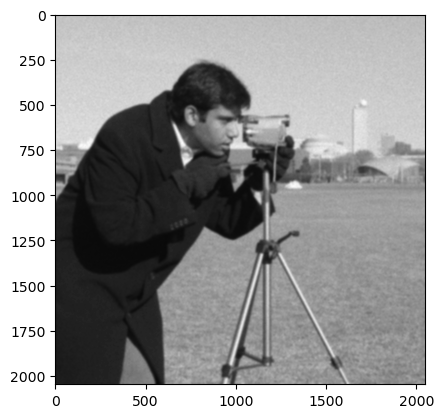

In [9]:
plt.imshow(w0.detach(), cmap='gray')

In [10]:
def coarse_condition_v2(y, grad_y, kappa, eta, y_last = None):
    with torch.no_grad():
        gcond = (matrix_norm(R(grad_y)) >= kappa * matrix_norm(grad_y))
        if gcond:
            if y_last is not None:
                y_diff_norm = matrix_norm(y_last - y)
                y_norm = matrix_norm(y)
                return (y_diff_norm >= eta * y_norm)
            return True
        else:
            return False

In [11]:
def MLO_orthant(fh, y, lh, last_pts: list, l=0, kappa = 0.49, eps = 0.001):
    x = R(y).detach().requires_grad_(True)
    y0 = y.detach().requires_grad_(True)
    fhy0 = fh(y)
    fhy0.backward(retain_graph=True)
    grad_fhy0 = y.grad.clone()
    y.grad = None
    
    #if coarse_condition_v2(y, grad_fhy0, kappa, eps, last_pts[l]):
    #if coarse_condition_v3(grad_fhy0, kappa, eps):
    if True:
        print(l, ' : coarse correction activated')
        last_pts[l] = y.detach()
    
        x0 = x.detach().requires_grad_(True)
        fH = lambda x: kl_distance_rev(x, b[l+1], A[l+1])
        fHx0 = fH(x0)
        fHx0.backward(retain_graph = True)
        grad_fHx0 = x0.grad.clone()
        x0.grad = None

        kappa = R(grad_fhy0) - grad_fHx0

        del grad_fHx0

        with torch.no_grad():
            psi = lambda x: fH(x) + torch.sum(kappa * x)
            lH = orthant_bounds(y, x, P_inf, lh, P_nonzero[l])
        
        for i in range(maxIter[l]):
            #x.retain_grad()
            val = fcts.mirror_descent_IS(psi, x, tau[l+1], lH)
            x = val.detach().requires_grad_(True)
            del val
            x.grad = None
            
        if l < max_levels-1:
            x, last_pts = MLO_orthant(psi, x, lH, last_pts, l+1)

        d = P(x-x0)
        z, _ = armijo_linesearch(fh, y0, d)
        y = z.detach().requires_grad_(True)
    else: 
        print(l, ' : coarse correction not activated')
    
    for i in range(maxIter[l]):
        #y.retain_grad()
        yval = fcts.mirror_descent_IS(fh, y, tau[l], lh)
        y = yval.detach().requires_grad_(True)
        del yval
        y.grad = None
    return y, last_pts


In [12]:
# with torch.autograd.profiler.profile(use_cuda=True) as prof:
#     z0 = torch.ones(N, N) * 0.5
#     z0.requires_grad_(True)
#     last_pts = [None]*(max_levels+1)

#     lh = torch.zeros_like(z0)

#     MLO_orthant(fh, z0, lh, last_pts)
# print(prof.key_averages().table(sort_by="self_cuda_time_total"))

In [13]:
z0 = torch.ones(N, N) * 0.5
z0.requires_grad_(True)
last_pts = [None]*(max_levels+1)

lh = torch.zeros_like(z0)

rel_f_err = []
rel_f_err.append((matrix_norm(z0 - x_torch)/matrix_norm(z0)).item())

iteration_times_ML = []
iteration_times_ML.append(0)
overall_start_time_ML = time.time()

for i in range(5):
    iteration_start_time_ML = time.time()
    
    val, ylast = MLO_orthant(fh, z0, lh, last_pts)
    iteration_end_time_ML = time.time()
    iteration_time_ML = iteration_end_time_ML - iteration_start_time_ML

    iteration_times_ML.append(iteration_time_ML)
    z0 = val.clone().detach().requires_grad_(True)
    rel_f_err.append((matrix_norm(z0-x_torch)/matrix_norm(z0)).item())
    
    print(f"Iteration {i}: {fh(z0)} - Time: {iteration_time_ML:.6f} seconds")

overall_end_time_ML = time.time()  # End overall timing
overall_time_ML = overall_end_time_ML - overall_start_time_ML  # Calculate overall elapsed time

print(f"Overall time for all iterations: {overall_time_ML:.6f} seconds")

cumaltive_times_ML = [sum(iteration_times_ML[:i+1]) for i in range(len(iteration_times_ML))]

0  : coarse correction activated
1  : coarse correction activated
2  : coarse correction activated
3  : coarse correction activated
4  : coarse correction activated
5  : coarse correction activated
Iteration 0: 467884.4847517842 - Time: 69.870488 seconds
0  : coarse correction activated
1  : coarse correction activated
2  : coarse correction activated
3  : coarse correction activated
4  : coarse correction activated
5  : coarse correction activated
Iteration 1: 465483.0654694218 - Time: 67.918640 seconds
0  : coarse correction activated
1  : coarse correction activated
2  : coarse correction activated
3  : coarse correction activated
4  : coarse correction activated
5  : coarse correction activated
Iteration 2: 463101.9071465455 - Time: 68.243580 seconds
0  : coarse correction activated
1  : coarse correction activated
2  : coarse correction activated
3  : coarse correction activated
4  : coarse correction activated
5  : coarse correction activated
Iteration 3: 460740.644915556 - Time:

In [14]:
z0.min()

tensor(0.4921, grad_fn=<MinBackward1>)

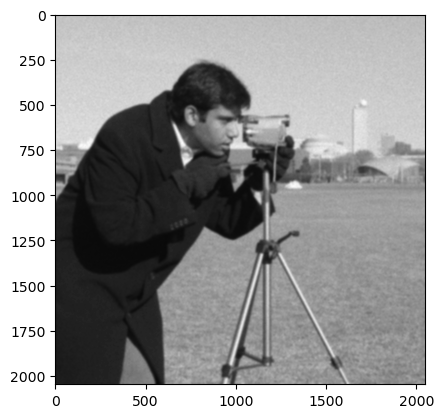

In [15]:
plt.imshow(w0.detach(), cmap='gray')

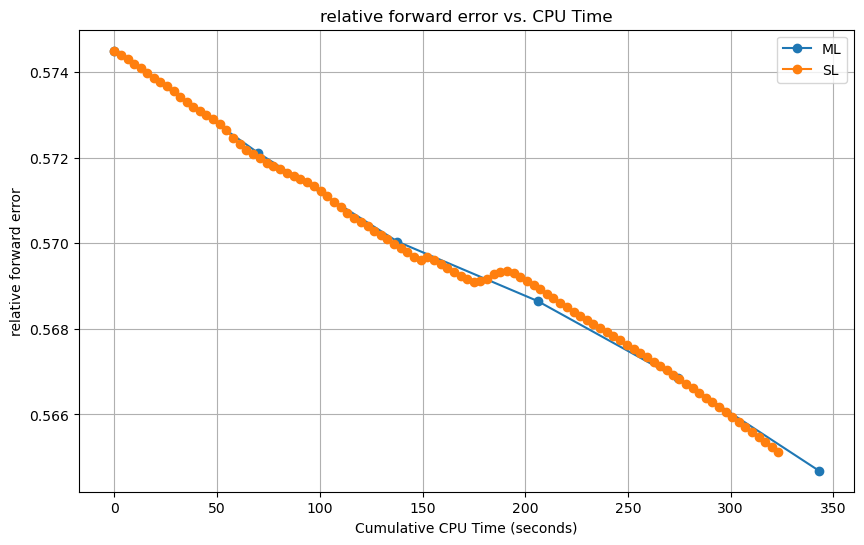

In [16]:
plt.figure(figsize=(10, 6))
#plt.plot(cumaltive_times_ML, fval_ML, marker='o', linestyle='-', label = 'ML')
#plt.plot(cumaltive_times_SL, fval_SL, marker='o', linestyle='-', label = 'SL')
plt.plot(cumaltive_times_ML, rel_f_err, marker='o', linestyle='-', label = 'ML')
plt.plot(cumaltive_times_SL, rel_f_err_SL, marker='o', linestyle='-', label = 'SL')
plt.xlabel('Cumulative CPU Time (seconds)')
plt.ylabel('relative forward error')
plt.title('relative forward error vs. CPU Time')
plt.grid(True)
plt.legend()
plt.show()